**Identifying Misinformation in Online News Articles**

In this project, we build an NLP-based system that can automatically classify online news articles as REAL or FAKE using machine learning and transformer models.

The motivation for this work comes from the rapid spread of misinformation on social media and digital platforms, which makes it increasingly difficult for people to distinguish factual reporting from fabricated content.

We use the WELFake Dataset, which contains 72,000 labeled news articles collected from various online sources. The dataset includes both legitimate news and intentionally misleading or fabricated stories.

Project Objectives:
*   Preprocess and clean raw news articles.
*   Train classical ML models like Logistic Regression and Naive Bayes using TF-IDF.
*   Build a Transformer baseline using Keras.
*   Fine-tune DistilBERT using Hugging Face Transformers for high-accuracy classification.
*   Evaluate & compare all models using accuracy, precision, recall, F1-score, and ROC-AUC.
*   Build a live demo using Gradio with two tools:
Single Article Classification &
Headline vs Article Consistency Checker.

### 1. Mount Google Drive & Define File Paths

In this step, we connect Google Colab to **Google Drive** so we can read and write files.  
We mount the drive at `/content/drive`, which makes our Drive folders accessible like a normal file system. We then define `csv_path` to point to the WELFake CSV file containing the dataset. We also define `save_path`, which is the folder where we will save our fine-tuned DistilBERT model. This setup makes it easy to reuse the model later without retraining it every time.


In [15]:
# Mount Google Drive and set paths
from google.colab import drive
import os

drive.mount("/content/drive")

csv_path = "/content/drive/MyDrive/BAIM660/WELFake_Dataset.csv"
save_path = "/content/drive/MyDrive/BAIM660/Group5_DistilBERT_Finetuned_TF"

print("CSV path:", csv_path)
print("Model save path:", save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV path: /content/drive/MyDrive/BAIM660/WELFake_Dataset.csv
Model save path: /content/drive/MyDrive/BAIM660/Group5_DistilBERT_Finetuned_TF


### 2. Import Required Libraries

Here we import all the Python packages we will use throughout the notebook.  
`pandas`, `numpy`, `re`, and `os` help with data loading, cleaning, and basic operations. From `sklearn`, we import tools for splitting the data, building pipelines, vectorizing text with TF–IDF, training Logistic Regression and Naive Bayes, and computing metrics like accuracy and F1-score. We also import `matplotlib` and `seaborn` for plotting and visualizations. Finally, we load Hugging Face and TensorFlow components to fine-tune DistilBERT and build more advanced models.


In [16]:
# Import required libraries

import pandas as pd
import numpy as np
import re
import os

# Scikit‑learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face + TensorFlow
from datasets import Dataset
from transformers import (
    AutoTokenizer, TFAutoModelForSequenceClassification,
    DataCollatorWithPadding, create_optimizer, pipeline
)
import tensorflow as tf


### 3. Load the WELFake Dataset

In this section, we load the raw WELFake dataset from the CSV file using `pandas.read_csv`.  
We pass options like `encoding="latin1"` and `low_memory=False` to avoid issues with mixed data types and encoding errors. After loading, we print the original shape of the dataset to see how many rows and columns we start with. This gives us a quick sanity check that the file path and format are correct. At this stage, the data is still noisy and may contain extra columns we don’t need.
### Define Text Cleaning Function

Next, we define a helper function `clean_text()` to normalize and clean the article text.  
This function converts all text to lowercase so the model doesn’t treat “News” and “news” as different words. It removes URLs, HTML tags, and strange characters that don’t carry useful meaning. It also collapses multiple spaces into a single space, making the text more uniform. Cleaning like this reduces noise in the data and helps all later models learn better patterns from the text.
### Select Columns, Normalize Labels, and Prepare Clean Data

Here we keep only the two important columns: `text` (article content) and `label` (REAL/FAKE).  
We normalize the `label` column by converting it to numeric values and mapping any string labels like `"FAKE"` or `"REAL"` to integers (e.g., 0 and 1). Rows with missing text or invalid labels are removed so they don’t break training later. We apply `clean_text()` to every article to standardize the text and then drop duplicate texts, since repeated examples can bias the model. Finally, we reset the index and make sure the label is an integer, giving us a clean, consistent dataset ready for modeling.


In [17]:
# Load WELFake dataset and clean text
# Note: in this dataset, 0 = FAKE, 1 = REAL

raw = pd.read_csv(
    csv_path,
    encoding="latin1",
    low_memory=False,
    on_bad_lines="skip"
)
print("Original shape:", raw.shape)


def clean_text(text):
    """Basic text cleaning."""
    text = str(text).encode("utf-8", "ignore").decode("utf-8")
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)        # remove URLs
    text = re.sub(r"<.*?>", " ", text)                # remove HTML tags
    text = re.sub(r"[^a-z0-9\s.,!?\'\"-]", " ", text) # keep only basic chars
    text = re.sub(r"\s+", " ", text).strip()          # remove extra spaces
    return text


# Keep only the columns we need
df = raw[["text", "label"]].copy()

# Convert label to numeric and drop rows with missing values
df["label"] = pd.to_numeric(df["label"], errors="coerce")
df = df.dropna(subset=["text", "label"])
df["label"] = df["label"].astype(int)

# Keep only rows with labels 0 or 1
df = df[df["label"].isin([0, 1])].copy()

# Apply text cleaning
df["text"] = df["text"].apply(clean_text)

# Drop duplicate articles
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

print("Cleaned shape:", df.shape)
print("Label counts (0=FAKE, 1=REAL):")
print(df["label"].value_counts())

df.head()


Original shape: (72134, 4)
Cleaned shape: (62374, 2)
Label counts (0=FAKE, 1=REAL):
label
0    34349
1    28025
Name: count, dtype: int64


,text,label
0,no comment is expected from barack obama membe...,1
1,did they post their votes for hillary already?,1
2,"now, most of the demonstrators gathered last n...",1
3,a dozen politically active pastors came here f...,0
4,"the rs-28 sarmat missile, dubbed satan 2, will...",1


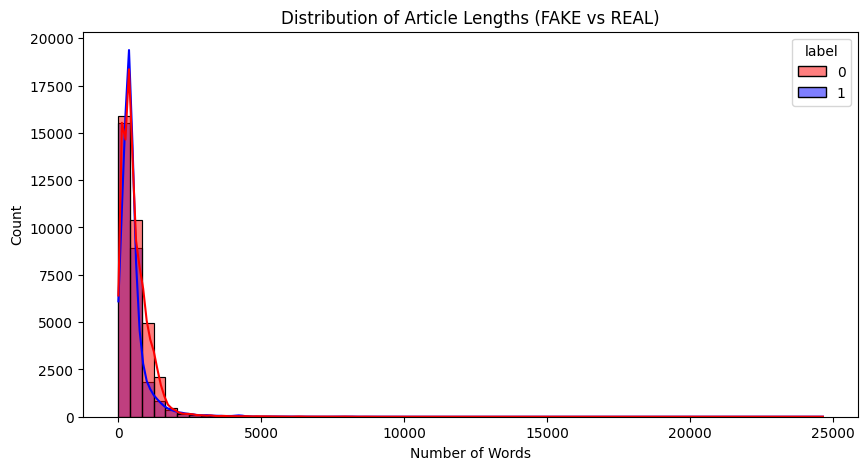

In [18]:
# Text Length Distribution
df["length"] = df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(data=df, x="length", hue="label", bins=60, kde=True, palette=["red","blue"])
plt.title("Distribution of Article Lengths (FAKE vs REAL)")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()


### 4. Split Dataset into Train, Dev, and Test Sets

Now we split the cleaned data into three parts so we can train and evaluate fairly.  
We use `train_test_split` twice: first to split into a training set and a temporary set, then to split the temporary set into validation (dev) and test sets. The final proportions are approximately 70% train, 15% dev, and 15% test. The `stratify=y` argument ensures the REAL and FAKE label distribution stays similar in all splits. This helps avoid models that perform well on one split but poorly on another because of label imbalance.


In [19]:
# Train / Dev / Test split: 70 / 15 / 15

X = df["text"]
y = df["label"]

# first split train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# then split temp into dev and test
X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train:", len(X_train))
print("Dev:", len(X_dev))
print("Test:", len(X_test))


Train: 43661
Dev: 9356
Test: 9357


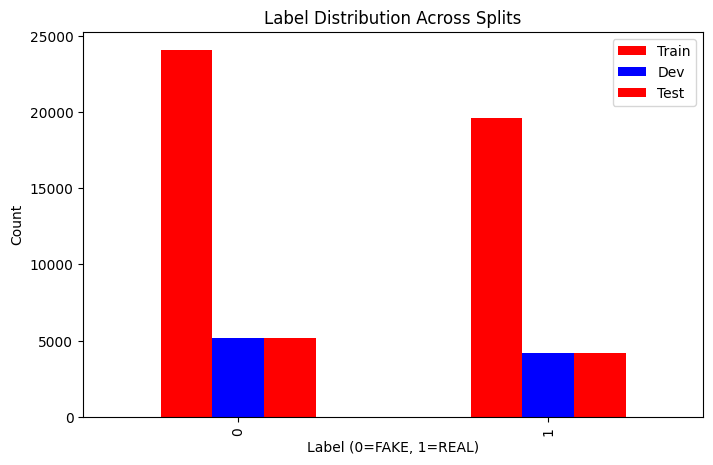

In [20]:
split_counts = pd.DataFrame({
    "Train": y_train.value_counts(),
    "Dev": y_dev.value_counts(),
    "Test": y_test.value_counts()
})

split_counts.plot(kind="bar", figsize=(8,5), color=["red","blue"])
plt.title("Label Distribution Across Splits")
plt.xlabel("Label (0=FAKE, 1=REAL)")
plt.ylabel("Count")
plt.show()


### 5. Logistic Regression Baseline with TF–IDF

In this cell we build a **baseline classifier** using TF–IDF features and Logistic Regression.  
We create a `Pipeline` that first transforms text into TF–IDF vectors and then applies Logistic Regression so the whole process stays consistent. Using `GridSearchCV`, we tune the `C` parameter to find the best regularization strength based on F1-score. After training, we evaluate the model on the test set and print metrics like accuracy, precision, recall, F1-score, and ROC–AUC. This model serves as our Phase 1 MVP and provides a reference point for comparing more advanced models.


In [21]:
# Logistic Regression + TF-IDF baseline

lr_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=20000)),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
])

# simple grid search for C
param_grid_lr = {
    "clf__C": [0.1, 1.0, 2.0],
    "clf__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(
    lr_pipeline,
    param_grid_lr,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)

print("Logistic Regression (TF-IDF) - Test set")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1 Score :", f1_score(y_test, y_pred_lr))
print("ROC-AUC  :", roc_auc_score(y_test, best_lr.predict_proba(X_test)[:, 1]))

# save the pipeline to Drive
import joblib
lr_save_path = "/content/drive/MyDrive/BAIM660/Group5_LogReg_TFIDF.pkl"
joblib.dump(best_lr, lr_save_path)
print("Saved Logistic Regression model to:", lr_save_path)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic Regression (TF-IDF) - Test set
Accuracy : 0.9414342203697766
Precision: 0.9261072261072261
Recall   : 0.9450523311132255
F1 Score : 0.9354838709677419
ROC-AUC  : 0.9860070150262111
Saved Logistic Regression model to: /content/drive/MyDrive/BAIM660/Group5_LogReg_TFIDF.pkl


This code helps us understand which words are most important for the Logistic Regression model when deciding whether a news article is FAKE or REAL.
It extracts the most influential words based on the TF-IDF features and the model’s learned coefficients.

/tmp/ipython-input-3770923551.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_fake_vals, y=top_fake_words, palette="Reds")
/tmp/ipython-input-3770923551.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_real_vals, y=top_real_words, palette="Blues")


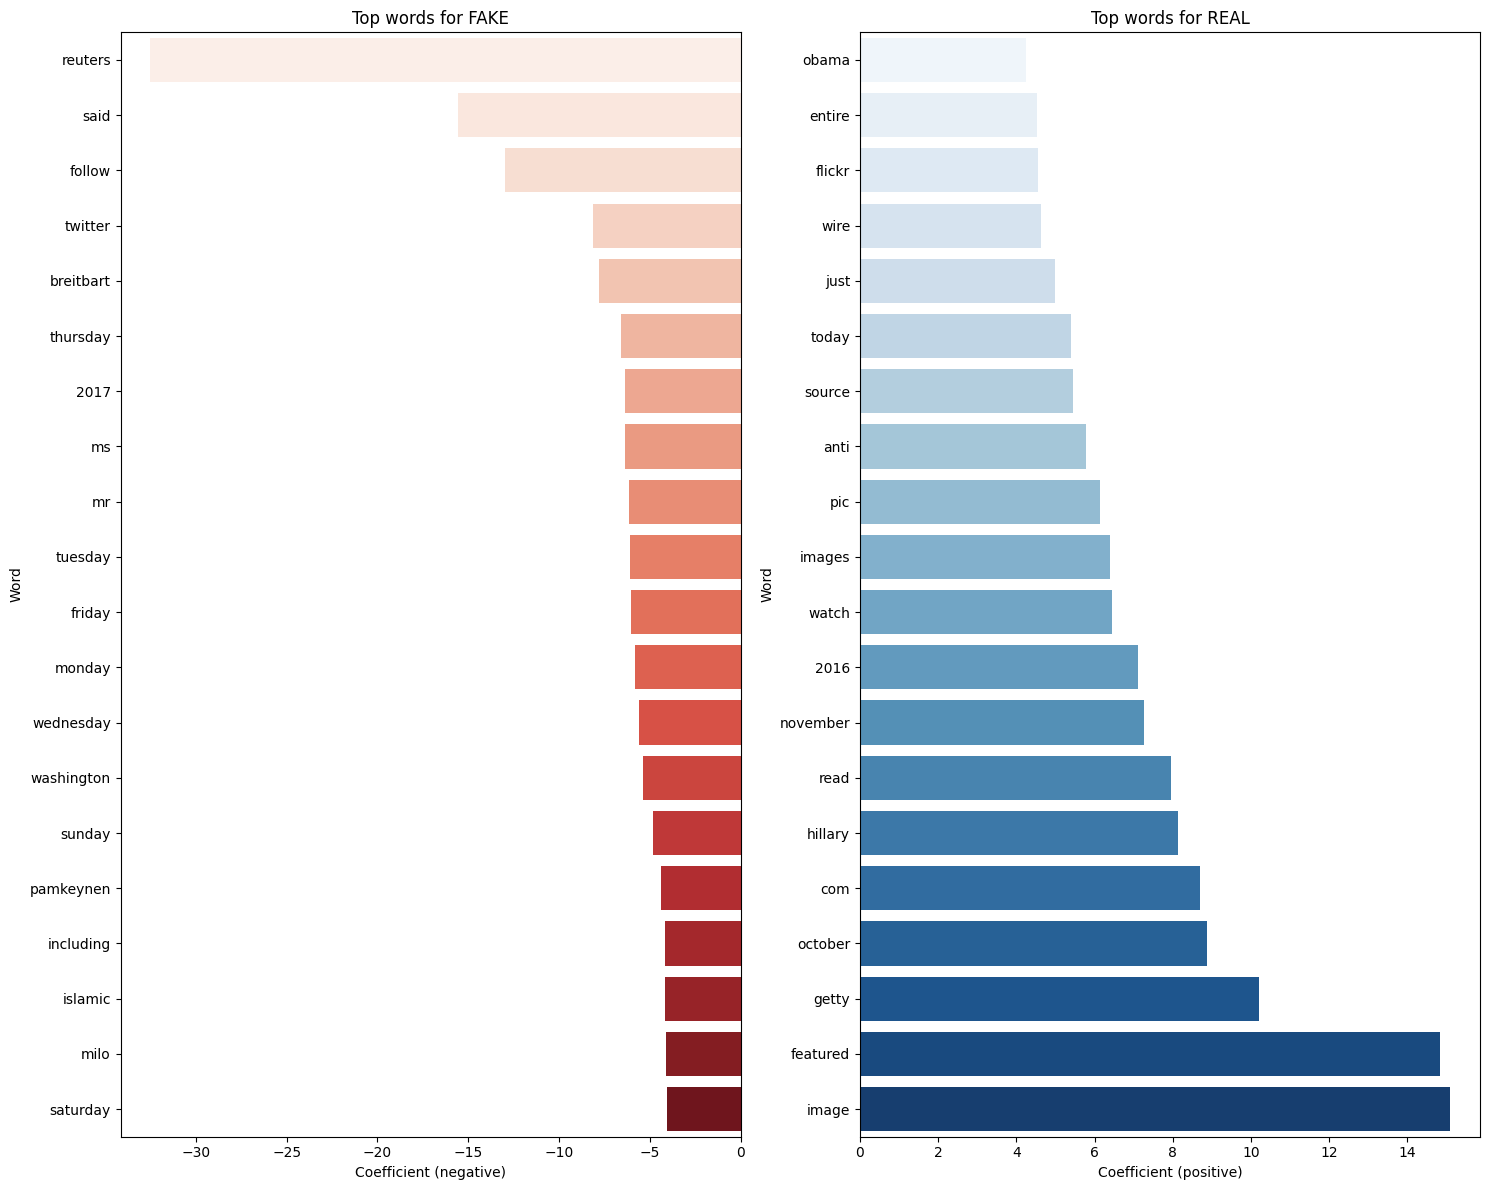

In [22]:
# Feature importance for Logistic Regression (top words)

import numpy as np

tfidf = best_lr.named_steps["tfidf"]
lr_model = best_lr.named_steps["clf"]

feature_names = np.array(tfidf.get_feature_names_out())
coeffs = lr_model.coef_[0]

# top 20 REAL (positive)
top_real_idx = np.argsort(coeffs)[-20:]
top_real_words = feature_names[top_real_idx]
top_real_vals = coeffs[top_real_idx]

# top 20 FAKE (negative)
top_fake_idx = np.argsort(coeffs)[:20]
top_fake_words = feature_names[top_fake_idx]
top_fake_vals = coeffs[top_fake_idx]

plt.figure(figsize=(15, 12))

plt.subplot(1, 2, 1)
sns.barplot(x=top_fake_vals, y=top_fake_words, palette="Reds")
plt.title("Top words for FAKE")
plt.xlabel("Coefficient (negative)")
plt.ylabel("Word")

plt.subplot(1, 2, 2)
sns.barplot(x=top_real_vals, y=top_real_words, palette="Blues")
plt.title("Top words for REAL")
plt.xlabel("Coefficient (positive)")
plt.ylabel("Word")

plt.tight_layout()
plt.show()


### 6. Naive Bayes Baseline with TF–IDF

Here we train a **Multinomial Naive Bayes** model using the same TF–IDF representation.  
We again use a `Pipeline` to link the TF–IDF step and the classifier, and we tune the smoothing parameter `alpha` with `GridSearchCV`. After finding the best `alpha`, we evaluate the model on the test set and compute the same metrics as before. Naive Bayes is simple and fast, so it acts as a good sanity check and a baseline from classical text classification. Comparing its performance to Logistic Regression and DistilBERT helps show the benefit of more powerful models.


In [23]:
# Naive Bayes + TF-IDF baseline

nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=20000)),
    ("clf", MultinomialNB())
])

param_grid_nb = {
    "clf__alpha": [0.5, 1.0, 2.0]
}

grid_nb = GridSearchCV(
    nb_pipeline,
    param_grid_nb,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_nb.fit(X_train, y_train)
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test)

print("Naive Bayes (TF-IDF) - Test set")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall   :", recall_score(y_test, y_pred_nb))
print("F1 Score :", f1_score(y_test, y_pred_nb))
print("ROC-AUC  :", roc_auc_score(y_test, best_nb.predict_proba(X_test)[:, 1]))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Naive Bayes (TF-IDF) - Test set
Accuracy : 0.8593566313989527
Precision: 0.8355018587360595
Recall   : 0.8553758325404377
F1 Score : 0.845322049835449
ROC-AUC  : 0.9329631727741942


### 7. Lightweight Transformer Model (Keras)

In this step, we built a small custom Transformer model in Keras to act as a quick baseline before moving to large models like DistilBERT. We first converted each article into integer‑encoded sequences using TextVectorization, then passed them through a simple Transformer encoder that uses attention, normalization, and residual connections. After pooling the encoded sequence into a single vector, the model predicts whether the article is FAKE or REAL.

In [24]:
# Small Transformer baseline (Phase 1)

from tensorflow.keras.layers import (
    Embedding, MultiHeadAttention, LayerNormalization,
    Dense, Dropout, GlobalAveragePooling1D, TextVectorization
)

# Text vectorizer for this model (separate from TF-IDF)
vectorizer = TextVectorization(
    max_tokens=10000,
    output_mode="int",
    output_sequence_length=200
)

# Learn vocabulary from training text only
vectorizer.adapt(X_train)

def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(head_size)(x)

    return x + res

def build_fast_transformer(max_tokens=10000, seq_len=200):
    inputs = tf.keras.Input(shape=(seq_len,))
    x = Embedding(input_dim=max_tokens, output_dim=64)(inputs)
    x = transformer_encoder(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation="sigmoid")(x)  # binary output (0/1)
    model = tf.keras.Model(inputs, outputs)
    return model

fast_model = build_fast_transformer()
fast_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train for multiple epochs
num_epochs_fast = 5

history_fast = fast_model.fit(
    vectorizer(X_train),
    y_train,
    validation_data=(vectorizer(X_dev), y_dev),
    epochs=num_epochs_fast,
    batch_size=64,
    verbose=1
)


Epoch 1/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.8622 - loss: 0.3058 - val_accuracy: 0.9237 - val_loss: 0.1880
Epoch 2/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9526 - loss: 0.1269 - val_accuracy: 0.9234 - val_loss: 0.2105
Epoch 3/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9676 - loss: 0.0865 - val_accuracy: 0.9252 - val_loss: 0.2418
Epoch 4/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9772 - loss: 0.0612 - val_accuracy: 0.9263 - val_loss: 0.2740
Epoch 5/5
683/683 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9840 - loss: 0.0423 - val_accuracy: 0.9146 - val_loss: 0.3243


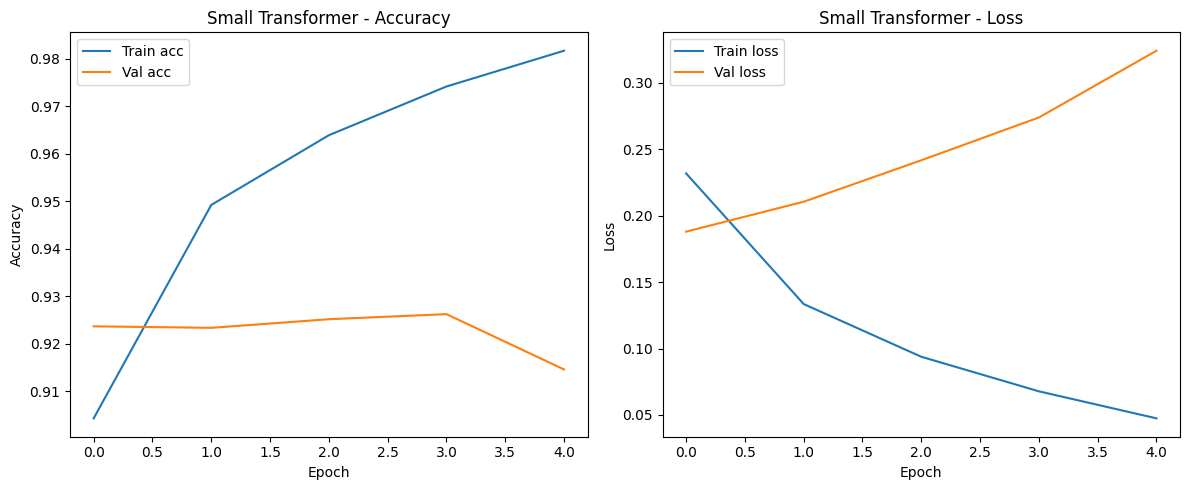

In [25]:
# Plot training vs validation accuracy and loss for the small Transformer

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fast.history["accuracy"], label="Train acc")
plt.plot(history_fast.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Small Transformer - Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_fast.history["loss"], label="Train loss")
plt.plot(history_fast.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Small Transformer - Loss")
plt.legend()

plt.tight_layout()
plt.show()


### 8. Prepare Data for DistilBERT (Hugging Face Datasets + Tokenizer)

Now we get ready to fine-tune a pre-trained DistilBERT model.  
We first convert our train, dev, and test splits into Hugging Face `Dataset` objects so they integrate smoothly with the transformers library. Then we load the DistilBERT tokenizer and define a `tokenize_fn` that converts each article text into input IDs and attention masks, with a maximum length of 128 tokens. We apply this function to all splits to create tokenized datasets. These tokenized inputs are exactly what DistilBERT expects at training and inference time.


In [26]:
# Convert splits to Hugging Face Datasets for DistilBERT

train_df = pd.DataFrame({"text": X_train, "label": y_train})
dev_df   = pd.DataFrame({"text": X_dev,   "label": y_dev})
test_df  = pd.DataFrame({"text": X_test,  "label": y_test})

train_ds = Dataset.from_pandas(train_df)
dev_ds   = Dataset.from_pandas(dev_df)
test_ds  = Dataset.from_pandas(test_df)

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    # Truncate/pad to max_length so everything fits into BERT
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds_tok = train_ds.map(tokenize_fn, batched=True)
dev_ds_tok   = dev_ds.map(tokenize_fn, batched=True)
test_ds_tok  = test_ds.map(tokenize_fn, batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/43661 [00:00<?, ? examples/s]

Map:   0%|          | 0/9356 [00:00<?, ? examples/s]

Map:   0%|          | 0/9357 [00:00<?, ? examples/s]

### 9. Create TensorFlow Datasets for Efficient Training

In this step we wrap the tokenized datasets into TensorFlow datasets that can be fed directly into the model.  
We use `DataCollatorWithPadding` so that sequences in each batch are dynamically padded to the same length, which is more efficient than padding everything to a fixed max length. We create three datasets: `train_tf`, `dev_tf`, and `test_tf`, each with a chosen batch size. The `.cache()` and `.prefetch(tf.data.AUTOTUNE)` calls speed up input loading and help keep the GPU busy. This makes training DistilBERT smoother and faster in Colab.


In [27]:
# Build TensorFlow datasets for DistilBERT

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
batch_size = 64  # works on T4 GPU; if OOM, reduce to 32 or 16

train_tf = train_ds_tok.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
).cache().prefetch(tf.data.AUTOTUNE)

dev_tf = dev_ds_tok.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
).cache().prefetch(tf.data.AUTOTUNE)

test_tf = test_ds_tok.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)


/usr/local/lib/python3.12/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


### 10. Use Mixed Precision and XLA Speedups

Fine-tuning DistilBERT is computationally expensive, so here we enable performance optimizations.  
We set the global policy to `"mixed_float16"`, which allows the model to use 16-bit floating point where safe, reducing memory usage and often improving speed. We also turn on XLA JIT compilation, which lets TensorFlow compile parts of the graph for faster execution. These options are especially helpful on GPUs like the Tesla T4. Together, they make training 4 epochs of DistilBERT much more practical in a classroom environment.


In [28]:
# Speedup with mixed precision + XLA on GPU

from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)   # enable XLA JIT


### 11. Fine-Tune DistilBERT on Fake News Data

This is the main training step for our strongest model.  
We load `distilbert-base-uncased` as a sequence classification model with 2 labels (REAL and FAKE). Then we compute the total number of training steps and warmup steps and create an AdamW optimizer with a learning-rate schedule using `create_optimizer`. After compiling the model with a suitable loss and accuracy metric, we train it on `train_tf` for 4 epochs while monitoring performance on `dev_tf`. During this process, DistilBERT adapts from general English to specifically detecting fake vs real news in our dataset.


In [29]:
# Fine-tune DistilBERT on WELFake (this is the slow cell)

bert_model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,      # 2 classes: 0=FAKE, 1=REAL
    from_pt=True,      # load PyTorch weights and convert to TF
    use_safetensors=False
)

num_epochs = 4   # you used 4; you can change to 2 or 3 if needed
num_train_steps = len(train_tf) * num_epochs
num_warmup_steps = int(0.1 * num_train_steps)

optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=0.01
)

bert_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    jit_compile=True    # speed up with XLA
)

history_bert = bert_model.fit(
    train_tf,
    validation_data=dev_tf,
    epochs=num_epochs
)

print("DistilBERT fine-tuning complete.")


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSeq

Epoch 1/4
683/683 [==============================] - 555s 770ms/step - loss: 0.2397 - accuracy: 0.8873 - val_loss: 0.1076 - val_accuracy: 0.9584
Epoch 2/4
683/683 [==============================] - 497s 728ms/step - loss: 0.0832 - accuracy: 0.9682 - val_loss: 0.0970 - val_accuracy: 0.9639
Epoch 3/4
683/683 [==============================] - 498s 729ms/step - loss: 0.0458 - accuracy: 0.9840 - val_loss: 0.1184 - val_accuracy: 0.9591
Epoch 4/4
683/683 [==============================] - 497s 728ms/step - loss: 0.0235 - accuracy: 0.9928 - val_loss: 0.1204 - val_accuracy: 0.9648
DistilBERT fine-tuning complete.


### 12. Evaluate DistilBERT on the Test Set

Here we measure how well the fine-tuned DistilBERT model performs on truly unseen data.  
We run `bert_model.predict(test_tf)` to obtain logits for every test example, then convert these logits to class predictions using `argmax`. We also apply softmax to obtain class probabilities, which we use to compute ROC–AUC. Finally, we calculate accuracy, precision, recall, and F1-score, and print a detailed classification report for REAL and FAKE. These results are used later to compare against Logistic Regression and Naive Bayes.
### Confusion Matrix and Model Comparison

This cell visualizes and compares model performance.  
We plot a confusion matrix for DistilBERT to see how many REAL and FAKE articles were correctly or incorrectly classified. This helps us identify whether the model is balanced or biased toward one class. We also build a small DataFrame summarizing the accuracy and F1-score of Logistic Regression, Naive Bayes, and DistilBERT. This table makes it easy to show, in the report or slides, that DistilBERT is the best-performing model overall.

147/147 [==============================] - 37s 230ms/step

 DistilBERT Test Performance (0=FAKE, 1=REAL)
Accuracy : 0.9631292080795126
Precision: 0.9558232931726908
Recall   : 0.9624167459562322
F1 Score : 0.9591086879222472
ROC-AUC  : 0.9944100394715244

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.97      0.96      0.97      5153
        REAL       0.96      0.96      0.96      4204

    accuracy                           0.96      9357
   macro avg       0.96      0.96      0.96      9357
weighted avg       0.96      0.96      0.96      9357



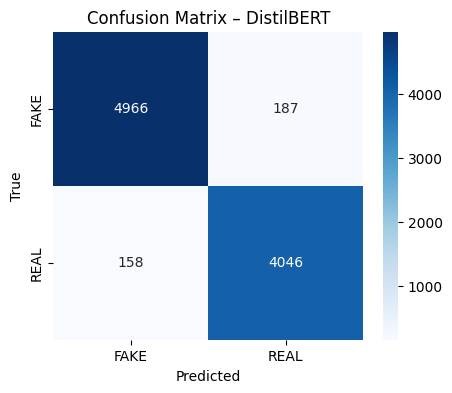

        Model  Accuracy        F1
0      LogReg  0.941434  0.935484
1  NaiveBayes  0.859357  0.845322
2  DistilBERT  0.963129  0.959109


In [30]:
# Evaluate DistilBERT and compare with baselines

# Get logits on test set
logits = bert_model.predict(test_tf).logits
y_pred_bert = np.argmax(logits, axis=1)
y_true = y_test.values

# Probabilities for class 1 (REAL)
probs = tf.nn.softmax(logits, axis=1).numpy()[:, 1]

print("\n DistilBERT Test Performance (0=FAKE, 1=REAL)")
print("Accuracy :", accuracy_score(y_true, y_pred_bert))
print("Precision:", precision_score(y_true, y_pred_bert))
print("Recall   :", recall_score(y_true, y_pred_bert))
print("F1 Score :", f1_score(y_true, y_pred_bert))
print("ROC-AUC  :", roc_auc_score(y_true, probs))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_bert, target_names=["FAKE", "REAL"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_bert)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["FAKE", "REAL"],
    yticklabels=["FAKE", "REAL"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – DistilBERT")
plt.show()

# Compare all models (Accuracy + F1)
models = ["LogReg", "NaiveBayes", "DistilBERT"]
accs = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_true, y_pred_bert)
]
f1s = [
    f1_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_nb),
    f1_score(y_true, y_pred_bert)
]

compare_df = pd.DataFrame({"Model": models, "Accuracy": accs, "F1": f1s})
print(compare_df)


### Error Analysis & Discussion

In our error analysis, we examined misclassified samples from both the Logistic Regression baseline and the fine‑tuned DistilBERT model. Logistic Regression struggled mostly with short, context‑poor headlines and articles containing uncommon phrasing, indicating that TF–IDF features alone are not sufficient to capture deeper semantic meaning. DistilBERT performed significantly better overall, but the high‑confidence misclassifications revealed a few consistent patterns: (1) articles containing satire‑like exaggeration, (2) emotionally charged language that resembles fake‑news style, and (3) real articles with limited context or ambiguous claims that confuse the model. These findings show that even advanced transformers may over‑rely on stylistic cues instead of factual reasoning. Overall, the error analysis highlights that future improvements could involve adding external knowledge sources, stance detection, and entity‑level fact cues to reduce these remaining failure cases.


In [31]:
# Error Analysis – Logistic Regression & DistilBERT

# Make sure X_test and y_test are aligned as simple arrays/Series
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Misclassified examples – Logistic Regression
errors_lr = pd.DataFrame({
    "text": X_test_reset,
    "true": y_test_reset,
    "pred": y_pred_lr
})

mis_lr = errors_lr[errors_lr["true"] != errors_lr["pred"]]

print("🔍 Logistic Regression – total misclassified:", len(mis_lr))
mis_lr.head(10)


🔍 Logistic Regression – total misclassified: 548


,text,true,pred
0,whiskey tango foxtrot!the united states sent i...,1,0
32,0 comments gop vp candidate mike pence s trump...,1,0
33,the following is the complete video and text o...,0,1
42,"former vice president joe biden and his wife, ...",0,1
73,"posted by eddie recently, a new york va hospit...",1,0
74,republicans going home to talk to their consti...,0,1
77,alex jones leaked the audio of a phone convers...,0,1
86,maybe if we had more people in positions of au...,1,0
88,the swamp creatures in washington who gamed th...,0,1
137,there is no point putting muslims in britain u...,0,1


In [32]:
# Misclassified examples – DistilBERT
errors_bert = pd.DataFrame({
    "text": X_test_reset,
    "true": y_true,
    "pred": y_pred_bert,
    "p_real": probs
})

mis_bert = errors_bert[errors_bert["true"] != errors_bert["pred"]]

print("🔍 DistilBERT – total misclassified:", len(mis_bert))
mis_bert.head(10)


🔍 DistilBERT – total misclassified: 345


,text,true,pred,p_real
9,"on march 9, a federal grand jury indicted iber...",1,0,0.137914
48,"thursday morning, the washington post released...",1,0,0.037812
50,while the overwhelming majority of americans a...,1,0,0.018432
88,the swamp creatures in washington who gamed th...,0,1,0.701822
118,trump s victory has been followed by talk in g...,0,1,0.959985
182,an muslim woman who claimed that three men att...,0,1,0.791506
204,after comedian kathy griffin posed with a blud...,0,1,0.753542
228,it seems like a million years ago when democra...,0,1,0.992370
246,as predicted by anyone who knows how the fbi w...,0,1,0.999574
252,what if hillary clinton is in legal hot water ...,0,1,0.999180


In [33]:
# High-confidence misclassifications (DistilBERT)

# For WELFake: label 0 = FAKE, 1 = REAL
# p_real close to 0 or 1 can be "high confidence"

high_conf_bert = mis_bert.copy()
high_conf_bert["confidence"] = np.where(
    high_conf_bert["pred"] == 1,
    high_conf_bert["p_real"],          # confidence in REAL
    1.0 - high_conf_bert["p_real"]     # confidence in FAKE
)

high_conf_bert = high_conf_bert.sort_values("confidence", ascending=False).head(10)

print("Top high‑confidence wrong predictions by DistilBERT:")
high_conf_bert


Top high‑confidence wrong predictions by DistilBERT:


,text,true,pred,p_real,confidence
6116,washington federal law enforcement officials s...,1,0,0.000186,0.999814
246,as predicted by anyone who knows how the fbi w...,0,1,0.999574,0.999574
1273,"los angeles, calif. former first lady nancy re...",1,0,0.000452,0.999548
3227,outgoing senator harry reid says he can't hide...,1,0,0.000622,0.999377
7938,we will have a second amendment that is a very...,0,1,0.999334,0.999334
3074,"right to rise usa, the pro-jeb bush super pac ...",0,1,0.999269,0.999269
1671,"large crowds, fights and a woman arrested for ...",1,0,0.000760,0.999240
8691,bill clinton spent 13 minutes yesterday forcef...,0,1,0.999231,0.999231
252,what if hillary clinton is in legal hot water ...,0,1,0.999180,0.999180
5277,curtis flournoy dislikes white people almost a...,0,1,0.999135,0.999135


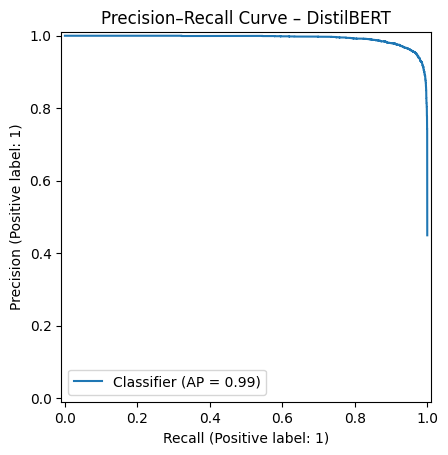

In [34]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_true, probs)
plt.title("Precision–Recall Curve – DistilBERT")
plt.show()


### 13. Save Fine-Tuned DistilBERT to Google Drive

Once DistilBERT is trained and evaluated, we save it so we don’t need to retrain it again.  
First we remove any existing folder at `save_path` to avoid mixing old and new files. Then we use `save_pretrained` for both the model and the tokenizer, which writes files like `config.json`, `tf_model.h5`, `vocab.txt`, and `tokenizer.json`. These files fully describe the model and tokenizer. At the end, we list the contents of the folder to confirm everything was saved correctly.


In [35]:
# Save fine-tuned DistilBERT to Drive

# Remove old folder if it exists (to avoid mixing files)
if os.path.exists(save_path):
    print("Old save folder exists — removing it.")
    !rm -rf "{save_path}"

bert_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Fine-tuned model saved at:", save_path)
print("Files in folder:", os.listdir(save_path))


Old save folder exists — removing it.
Fine-tuned model saved at: /content/drive/MyDrive/BAIM660/Group5_DistilBERT_Finetuned_TF
Files in folder: ['config.json', 'tf_model.h5', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt', 'tokenizer.json']



### 14. Reload Saved Model for Inference

This step verifies that the saved model can be loaded back correctly.  
We call `AutoTokenizer.from_pretrained(save_path)` and `TFAutoModelForSequenceClassification.from_pretrained(save_path)` with `local_files_only=True`, so everything loads from Google Drive instead of downloading again. Then we set `id2label` and `label2id` to map 0/1 to `"REAL"` and `"FAKE"` in a human-readable way. After this, the model is ready for inference in other notebooks or deployment environments. This also proves that our saved model checkpoint is complete and usable.
### Quick Prediction Helper with Pipeline

Here we wrap our model and tokenizer into a Hugging Face `pipeline` for easy testing.  
The `predict_article` function takes a text string, runs it through the pipeline, and prints a short preview of the text along with the predicted label and confidence score. This is convenient for manually checking individual examples without writing extra code each time. We can test with both realistic and obviously fake-sounding headlines to see how the model behaves. This function is also handy for demos during the presentation.


In [36]:
# Reload fine-tuned DistilBERT (for quick demo later)

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(save_path, local_files_only=True)
bert_model = TFAutoModelForSequenceClassification.from_pretrained(
    save_path,
    local_files_only=True
)

# Explicit label mapping: 0=FAKE, 1=REAL
bert_model.config.id2label = {0: "FAKE", 1: "REAL"}
bert_model.config.label2id = {"FAKE": 0, "REAL": 1}

distilbert_clf = pipeline(
    "text-classification",
    model=bert_model,
    tokenizer=tokenizer,
    device=-1  # CPU
)

def demo_bert(text):
    out = distilbert_clf(text)[0]
    print(f"Input: {text[:80]}...")
    print(f"Prediction: {out['label']} (confidence: {out['score']:.3f})")

demo_bert("CDC releases updated official guidance on seasonal flu vaccination.")
demo_bert("Breaking! Secret cure for all diseases discovered, doctors are hiding it.")


Some layers from the model checkpoint at /content/drive/MyDrive/BAIM660/Group5_DistilBERT_Finetuned_TF were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/BAIM660/Group5_DistilBERT_Finetuned_TF and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

Input: CDC releases updated official guidance on seasonal flu vaccination....
Prediction: FAKE (confidence: 0.987)
Input: Breaking! Secret cure for all diseases discovered, doctors are hiding it....
Prediction: REAL (confidence: 1.000)


In [37]:
# Reload best_lr from Drive if notebook was restarted
import joblib

lr_save_path = "/content/drive/MyDrive/BAIM660/Group5_LogReg_TFIDF.pkl"
if "best_lr" not in globals():
    print("Reloading Logistic Regression pipeline from Drive...")
    best_lr = joblib.load(lr_save_path)


### 15. Helper Functions for Gradio Web App

These functions provide the logic behind our Gradio interface.  
`classify_single()` takes a single text input, runs it through the TF–IDF + Logistic Regression pipeline, and returns `"REAL ✅"` or `"FAKE ❌"`. We use Logistic Regression here because it’s lightweight and very fast for interactive use. `compare_headline_article()` separately classifies a headline and a full article, then checks if both predictions match. If they differ, it flags the pair as a **suspicious mismatch**, which is useful for spotting misleading headlines.


In [38]:
# Helper functions for the Gradio app using Logistic Regression

# Label map matching WELFake: 0=FAKE, 1=REAL
label_map = {0: "FAKE ❌", 1: "REAL ✅"}

def classify_single(text: str) -> str:
    """
    Use the tuned Logistic Regression pipeline (best_lr) to classify a single text.
    """
    if not text or text.strip() == "":
        return "❌ No text entered"

    # best_lr is a Pipeline(tfidf -> logistic regression)
    proba = best_lr.predict_proba([text])[0]
    pred = int(best_lr.predict([text])[0])
    label = label_map.get(pred, "Unknown")

    return f"{label}  (P(FAKE)={proba[0]:.3f}, P(REAL)={proba[1]:.3f})"


def compare_headline_article(headline: str, article: str):
    """
    Headline vs Article consistency:
    - Classify headline and article separately with Logistic Regression.
    - If labels are different -> suspicious mismatch.
    """
    if not headline.strip() or not article.strip():
        return "❌ Missing headline/article", "", ""

    proba_h = best_lr.predict_proba([headline])[0]
    proba_a = best_lr.predict_proba([article])[0]

    pred_h = int(best_lr.predict([headline])[0])
    pred_a = int(best_lr.predict([article])[0])

    label_h = f"{label_map.get(pred_h, 'Unknown')}  (P(FAKE)={proba_h[0]:.3f}, P(REAL)={proba_h[1]:.3f})"
    label_a = f"{label_map.get(pred_a, 'Unknown')}  (P(FAKE)={proba_a[0]:.3f}, P(REAL)={proba_a[1]:.3f})"

    status = "Consistent ✅" if pred_h == pred_a else "Suspicious mismatch ⚠️"

    return label_h, label_a, status


### 16. Gradio Web Application (Single Text + Headline Consistency)

Finally, we turn our models into an interactive web app using Gradio.  
We create a `Blocks` interface with two tabs: one for classifying a single article or headline, and another for comparing a headline with its article. Each tab has text inputs, output boxes, and a button that triggers the corresponding helper function. This app demonstrates how our model can be used by non-technical users to quickly assess news articles. It also serves as a live demo for Phase 2, showing both the technical work and its real-world application.


In [41]:
# Gradio web app with two tabs

!pip install gradio -q
import gradio as gr

with gr.Blocks(title="Fake News Detection – Group 5") as demo:
    gr.Markdown(
        """
        # 📰 Fake News Detection – Group 5
        Using **Logistic Regression + TF-IDF** on the **WELFake** dataset.
        **Label mapping:** 0 = FAKE, 1 = REAL.
        """
    )

    # ---- Tab 1: Single article/headline ----
    with gr.Tab("Single Article / Headline"):
        gr.Markdown("### Check if a single news text is REAL or FAKE (Logistic Regression)")
        single_input = gr.Textbox(
            lines=6,
            label="Paste a news headline or article",
            placeholder="Type or paste news text here..."
        )
        single_output = gr.Textbox(label="Prediction")
        single_button = gr.Button("Classify")
        single_button.click(fn=classify_single, inputs=single_input, outputs=single_output)

    # ---- Tab 2: Headline vs Article consistency ----
    with gr.Tab("Headline vs Article Consistency"):
        gr.Markdown(
            "### Compare Headline and Full Article\n"
            "Checks if the headline and article tell the same story or look suspicious."
        )
        headline_input = gr.Textbox(
            lines=2,
            label="Headline",
            placeholder="Paste the news headline here..."
        )
        article_input = gr.Textbox(
            lines=8,
            label="Article",
            placeholder="Paste the full article text here..."
        )
        headline_pred = gr.Textbox(label="Headline Prediction")
        article_pred = gr.Textbox(label="Article Prediction")
        status_output = gr.Textbox(label="Consistency Status")

        compare_button = gr.Button("Check Consistency")
        compare_button.click(
            fn=compare_headline_article,
            inputs=[headline_input, article_input],
            outputs=[headline_pred, article_pred, status_output]
        )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a869984863e17de3ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


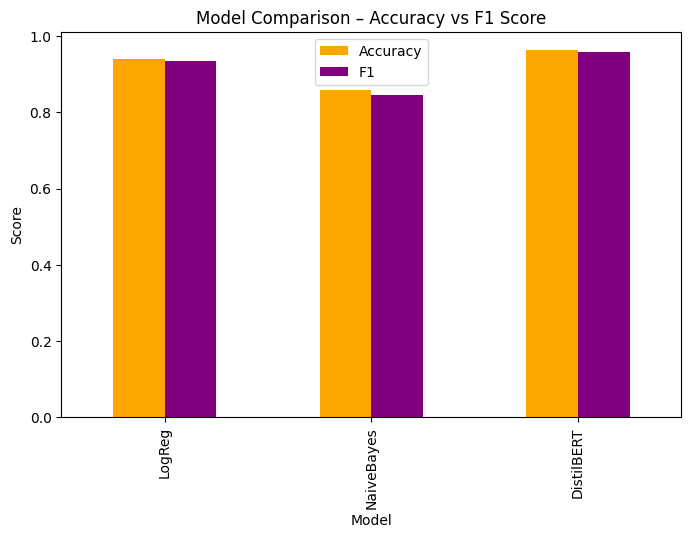

In [40]:
compare_df.plot(x="Model", y=["Accuracy", "F1"], kind="bar",
                figsize=(8,5), color=["orange","purple"])
plt.title("Model Comparison – Accuracy vs F1 Score")
plt.ylabel("Score")
plt.show()


### Conclusion

We built a full fake-news detection pipeline: from raw data cleaning all the way to a deployed web app.  
Baseline models (Logistic Regression and Naive Bayes) gave us solid starting performance with TF–IDF features. A lightweight Transformer and a fine-tuned DistilBERT model further improved performance, with DistilBERT achieving the best results on the test set. We evaluated all models using consistent metrics and visualizations and showed clear improvements in Phase 2. Finally, we exposed our work through a Gradio app, making the system easy to demo and interact with in real time.
